In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
data_tomato_price = pd.read_csv("data/data_tomato_price.csv")
data_tomato_price.head(3)

,date,tomato_price
0,2015-01-02,0.62
1,2015-01-09,0.33
2,2015-01-16,0.34


In [3]:
#I modified DataFrame to adapt to Prophet: the prophet package expects input as a dataframe with the first column indicating time and 
# the second indicating the time series we wish to forecast
df_prophet = data_tomato_price.rename(columns={'date': 'ds', 'tomato_price': 'y'})
df_prophet.head(3)

,ds,y
0,2015-01-02,0.62
1,2015-01-09,0.33
2,2015-01-16,0.34


In [4]:
# Development of training function: 
#I looked the outliers dates in exploratory data plot, and in the dataset
#Once the table is created, holiday effects are included in the forecast by passing them in with the holidays argument.

def train(df):
    outliers = pd.to_datetime(['2015-01-16', '2015-01-30', '2015-02-13', '2015-02-20', '2015-02-27', '2015-03-04', '2015-03-27', \
        '2016-01-01', '2016-01-15', '2016-01-22', '2016-01-29', '2016-03-25', \
        '2017-03-17', '2017-03-24', '2018-02-02', '2018-02-03', '2018-02-16', '2018-02-23', \
        '2018-03-16', '2018-03-23', '2018-03-30', '2018-09-21', '2018-09-28', \
        '2019-05-04', '2019-05-07', '2019-09-13', '2019-09-20', '2019-12-13', '2019-12-20', '2019-12-27'])
    
    outliers_days = pd.DataFrame({
    'holiday': 'Atypical',
    'ds'     : outliers
    })             
    #Prophet model
    forecast_model = Prophet(growth='linear',  weekly_seasonality=3, yearly_seasonality=3, holidays=outliers_days)
    model = forecast_model.fit(df)
    return model
                   

In [5]:
# Development of prediction function
#ts_test: list of date for four years when I wish the predictions

def predict(model, ts_test):
    
    preds = model.predict(ts_test)
    return preds

In [6]:
model = train(df_prophet)
# I get a suitable dataframe that extends into the future for four years using the helper method Prophet.make_future_dataframe
ts_test = model.make_future_dataframe(periods=1460, include_history=True)
preds = predict(model, ts_test)
preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1716,2023-12-22,0.678293,0.248966,1.057595
1717,2023-12-23,0.516653,0.121337,0.913779
1718,2023-12-24,0.506805,0.110971,0.910746
1719,2023-12-25,0.497026,0.076483,0.888637
1720,2023-12-26,0.487332,0.111802,0.909481


# Interpreting and understanding the model

Text(63.0, 0.5, 'yhat')

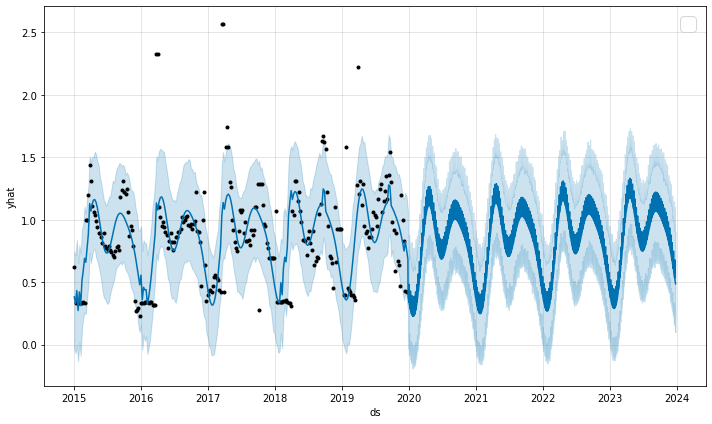

In [21]:
#To see how the model fits existing data and what a forecast over 4 years looks like.

model_predictions = model.predict(ts_test)

plot_pred = model.plot(model_predictions)
plt.legend(loc='best', fontsize=20)
plt.ylabel('yhat')

 In the plot, the black dots correspond to the observed tomato price each week. The dark blue line (labeled 'yhat') corresponds to the estimated tomato price on the estimated model. Finally, the light blue lines correspond to the 80% confidence interval for the models predictions.  

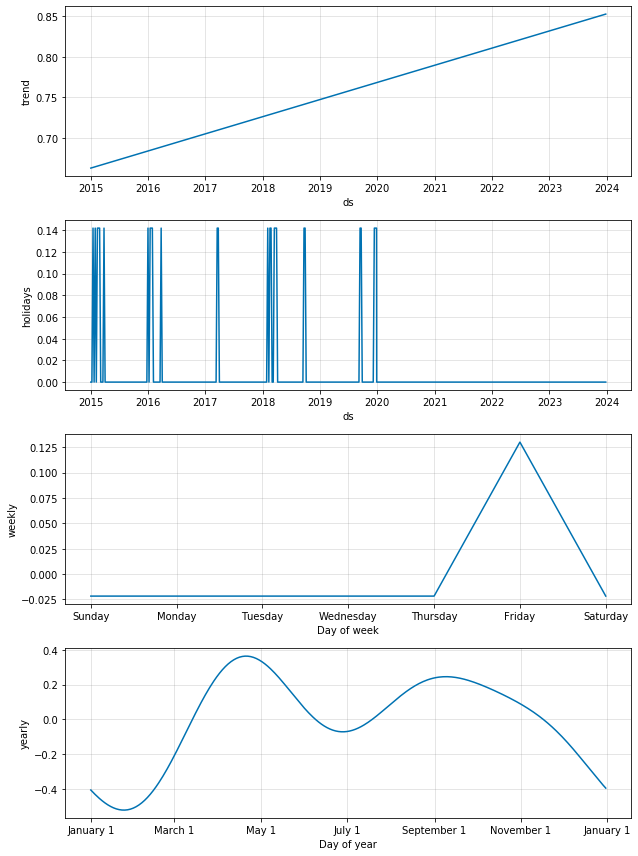

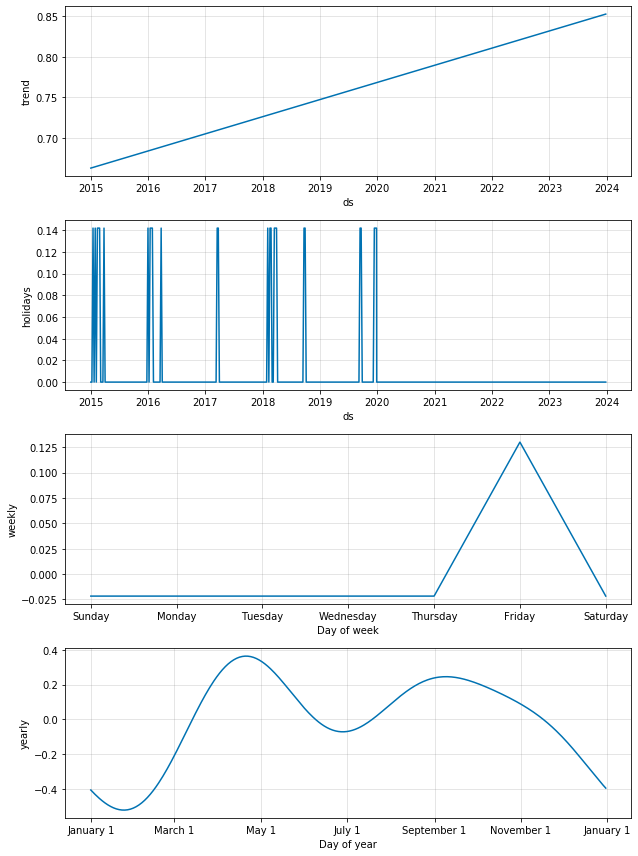

In [8]:
model.plot_components(model_predictions, uncertainty=False)

# Prophet Diagnostics

In [9]:
#Here, Prophet only identified a downward trend with no seasonality.
#Evaluate performance of the model by calculating its mean square  error (MSE) :

#Prophet includes functionality for time series cross validation to measure forecast error using historical data
#This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up 
#to that cutoff point. We can then compare the forecasted values to the actual values.
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(model, initial='730 days', period='1460 days', horizon = '365 days')
df_cv.mean()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-27 00:00:00 and 2018-12-27 00:00:00


yhat          0.887454
yhat_lower    0.503321
yhat_upper    1.272160
y             0.926154
dtype: float64

In [10]:
#These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). 
#By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head()


,horizon,mse,rmse,mae,mape,coverage
0,36 days,0.372305,0.610168,0.398601,0.383612,0.6
1,43 days,0.332946,0.577014,0.324975,0.324377,0.8
2,50 days,0.332504,0.576632,0.316257,0.302498,0.8
3,57 days,0.333658,0.577631,0.322115,0.317143,0.8
4,64 days,0.017221,0.131227,0.110756,0.265590,1.0


In [11]:
df_p.mean()

horizon     200 days 12:00:00
mse                  0.114963
rmse                 0.307713
mae                  0.252016
mape                 0.309305
coverage               0.8625
dtype: object

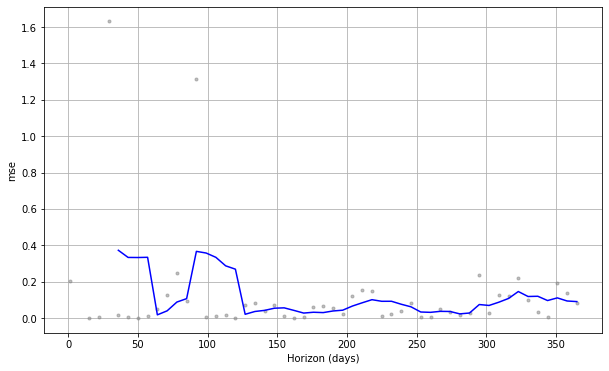

In [12]:
#Cross validation performance metrics
#Here shown for mse. Dots show the mean square error for each prediction. 
#The blue line shows the mse. 

from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mse')

In the figure, the initial period should be long enough to capture all of the components of the model: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.

## Comparison of mse without holidays parameters and adding changepoint_prior_scale parameter


In [13]:
def train_without_holidays(df):             
    #Prophet model
    forecast_model = Prophet(changepoint_prior_scale=0.01, growth='linear',  weekly_seasonality=3, yearly_seasonality=3)
    model = forecast_model.fit(df)
    return model

In [14]:
model_without_holidays = train_without_holidays(df_prophet)
# I get a suitable dataframe that extends into the future for four years 
#using the helper method Prophet.make_future_dataframe
preds_without_holidays = predict(model_without_holidays, ts_test)
preds_without_holidays[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1716,2023-12-22,0.571014,0.183451,0.973897
1717,2023-12-23,0.355619,-0.047433,0.734474
1718,2023-12-24,0.346337,-0.055777,0.746667
1719,2023-12-25,0.337131,-0.060746,0.734070
1720,2023-12-26,0.328015,-0.069496,0.747426


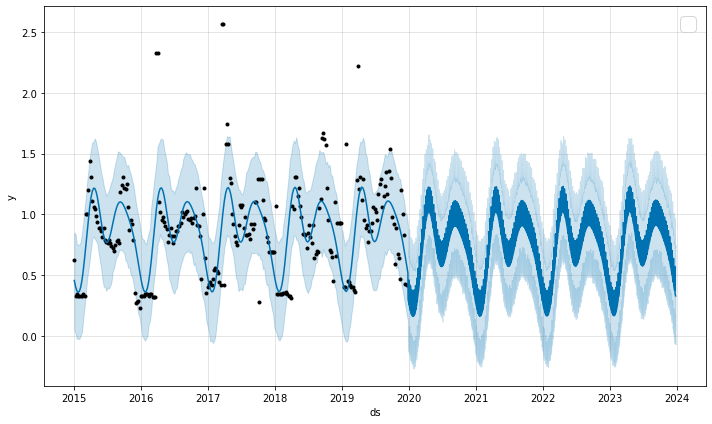

In [15]:
plot_pred = model.plot(preds_without_holidays)
plt.legend(loc='best', fontsize=20)

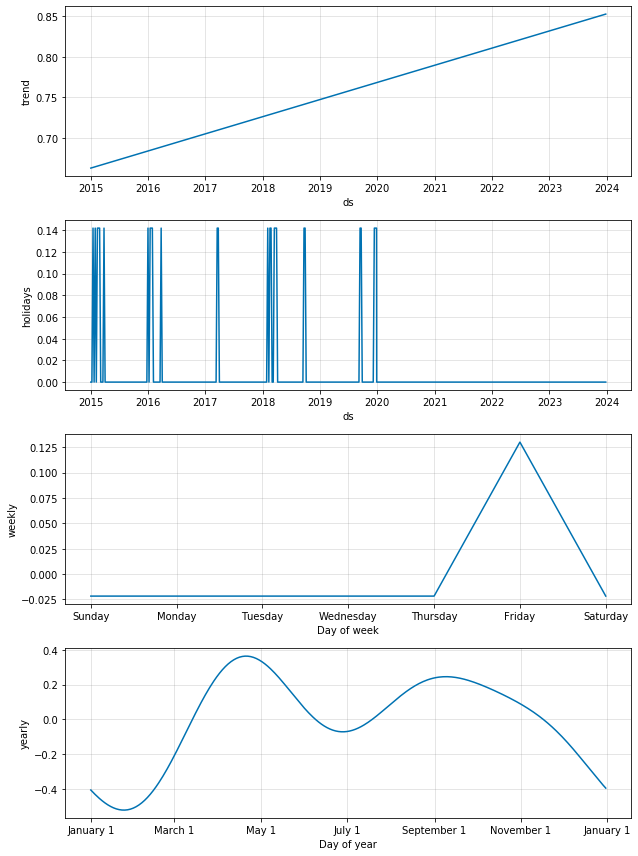

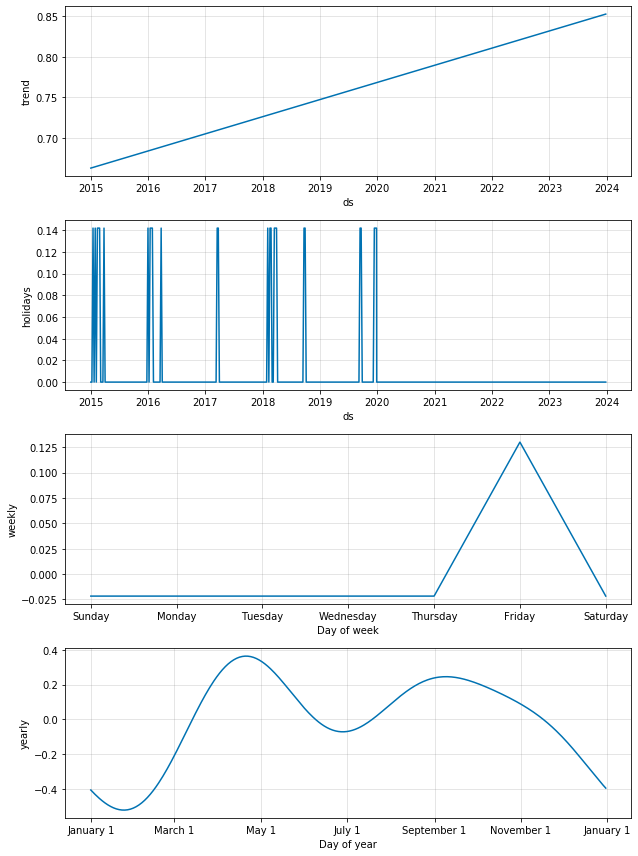

In [16]:
model.plot_components(model_predictions, uncertainty=False)

In [17]:
df_cv_without_holidays = cross_validation(model_without_holidays, initial='730 days', period='1460 days', horizon = '365 days')
df_cv_without_holidays.mean()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-12-27 00:00:00 and 2018-12-27 00:00:00


yhat          0.927447
yhat_lower    0.528503
yhat_upper    1.327713
y             0.926154
dtype: float64

In [18]:
df_p_without_holidays = performance_metrics(df_cv_without_holidays)
df_p_without_holidays.mean()

horizon     200 days 12:00:00
mse                  0.112645
rmse                 0.310213
mae                  0.253773
mape                 0.326644
coverage             0.879167
dtype: object

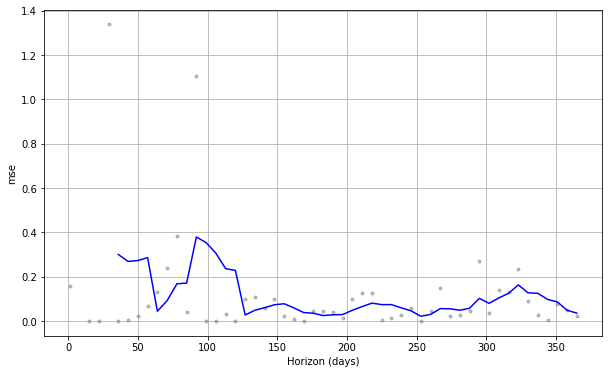

In [19]:
fig = plot_cross_validation_metric(df_cv_without_holidays, metric='mse')

The mean square error is slightly lower without holidays than with holidays selection 